In [ ]:
#Etape a faire avant de lancer le code
from google.colab import drive
drive.mount('/content/drive')

import os

# Chemin du dossier
projet_path = "/content/drive/MyDrive/ProjetM2"

# Vérifier si le dossier existe
if os.path.exists(projet_path):
    print("Le dossier existe !")
else:
    print("Le dossier n'existe pas.")

import zipfile

zip_path = "/content/drive/MyDrive/ProjetM2/Intel_Images.zip"
extract_path = "/content/ProjetM2"

# Extraire le zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée !")

KeyboardInterrupt: 

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/25
 439/8000 ━━━━━━━━━━━━━━━━━━━━ 2:15:54 1s/step - accuracy: 0.5302 - loss: 1.2086

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8000/8000 ━━━━━━━━━━━━━━━━━━━━ 574s 71ms/step - accuracy: 0.6457 - loss: 0.9355 - val_accuracy: 0.7787 - val_loss: 0.6039 - learning_rate: 1.0000e-04
Epoch 2/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 607s 70ms/step - accuracy: 0.7607 - loss: 0.6451 - val_accuracy: 0.8107 - val_loss: 0.5400 - learning_rate: 1.0000e-04
Epoch 3/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 558s 70ms/step - accuracy: 0.7868 - loss: 0.5811 - val_accuracy: 0.8217 - val_loss: 0.5034 - learning_rate: 1.0000e-04
Epoch 4/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 560s 70ms/step - accuracy: 0.7977 - loss: 0.5605 - val_accuracy: 0.8223 - val_loss: 0.4922 - learning_rate: 1.0000e-04
Epoch 5/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 568s 71ms/step - accuracy: 0.8043 - loss: 0.5312 - val_accuracy: 0.8267 - val_loss: 0.4812 - learning_rate: 1.0000e-04
Epoch 6/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 562s 70ms/step - accuracy: 0.8173 - loss: 0.5101 - val_accuracy: 0.8307 - val_loss: 0.4757 - learning_rate: 1.0000e-04
Epoch 7/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 566

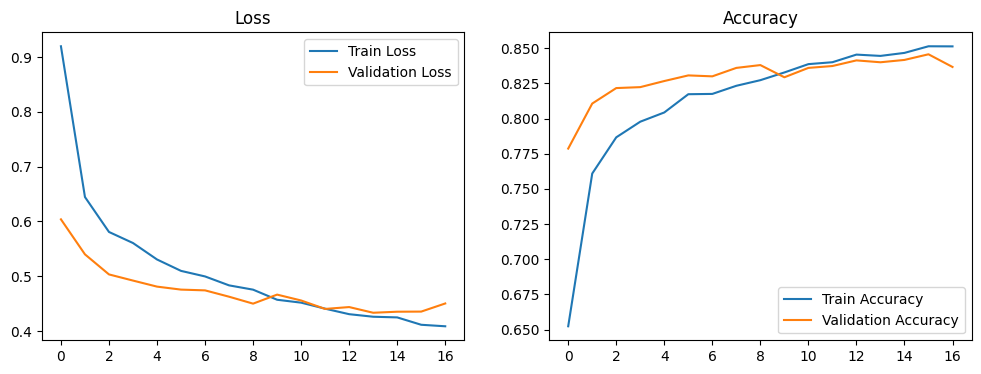

94/94 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step


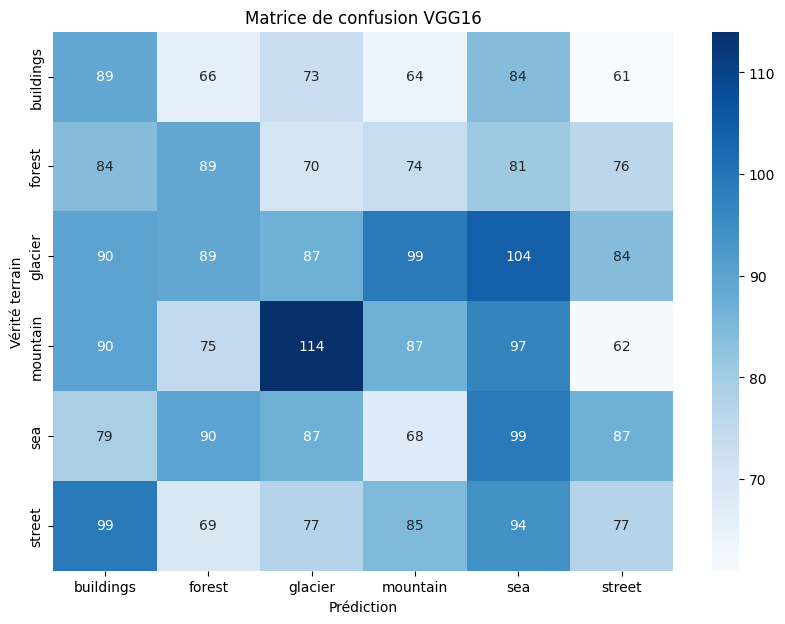

NameError: name 'svm_accuracy' is not defined

In [ ]:
# Importation des bibliothèques nécessaires
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.cluster import MiniBatchKMeans
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from scipy.cluster.vq import vq
import seaborn as sns

# Définition des chemins d'accès
train_path = "/content/ProjetM2/Intel_Images/seg_train/seg_train"
test_path = "/content/ProjetM2/Intel_Images/seg_test/seg_test"

# Fonction pour lister tous les fichiers dans un répertoire
def img_list(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

# Chargement des images et des étiquettes
def load_images_and_labels(path):
    class_names = os.listdir(path)
    image_paths = []
    image_classes = []
    for class_name in class_names:
        class_path = os.path.join(path, class_name)
        class_image_paths = img_list(class_path)
        image_paths += class_image_paths
        image_classes += [class_name] * len(class_image_paths)
    return image_paths, image_classes

# Chargement des données d'entraînement et de test
train_image_paths, train_image_classes = load_images_and_labels(train_path)
test_image_paths, test_image_classes = load_images_and_labels(test_path)

# Préparation des générateurs de données avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_path, target_size=(64, 64), batch_size=32, class_mode='categorical')
test_set = test_datagen.flow_from_directory(test_path, target_size=(64, 64), batch_size=32, class_mode='categorical')

# Charger le modèle VGG16 pré-entraîné sans les couches de classification
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Ajouter des couches de classification personnalisées
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

# Créer le modèle complet
model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Ajout des callbacks pour l'arrêt précoce et la réduction du taux d'apprentissage
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

# Entraîner le modèle
history = model.fit(training_set, steps_per_epoch=8000, epochs=25, validation_data=test_set, validation_steps=2000, callbacks=callbacks_list)

# Évaluation des résultats
loss, accuracy = model.evaluate(test_set)
print(f"Accuracy VGG16: {accuracy}")

# Affichage des courbes de loss et d'accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# Définir les noms des classes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Affichage de la matrice de confusion pour le modèle VGG16
y_pred_vgg16 = model.predict(test_set)
y_pred_vgg16_classes = np.argmax(y_pred_vgg16, axis=1)
y_true_vgg16 = test_set.classes

vgg16_cm = confusion_matrix(y_true_vgg16, y_pred_vgg16_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(vgg16_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de confusion VGG16')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()

